In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions import CSVLoggerCallback

# Preprocessing the data

In [2]:
train_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train"
test_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Test"
valid_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Validation"
train_dir_augmented = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train_augmented"

# Setup data inputs
IMG_SIZE = 128

#import data from directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

train_data_augmented = tf.keras.preprocessing.image_dataset_from_directory(train_dir_augmented,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis
train_data

Found 19173 files belonging to 7 classes.
Found 23846 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [3]:
class_names = train_data.class_names
class_names

['Atelectasis',
 'Effusion',
 'Infiltration',
 'Mass',
 'No_finding',
 'Nodule',
 'Pneumothorax']

## Preprocessing the dataset

In [4]:
#Creating a function to preprocess the images
def preprocess_img(image, label):
  """
  Converts image datatype from 'uint8' -> 'float32' 
  """
  return tf.cast(image, tf.float32), label 

In [5]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE) 
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to validation data
valid_data = valid_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Creating checkpoint callback

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='fine_tuning_best_model.h5',
    save_weights_only=False,  
    monitor='val_accuracy',  
    save_best_only=True, 
    verbose=1  
)

# Creating an augmenting contrast layer

In [7]:
from tensorflow.keras import layers, Model, regularizers

def contrast_enhancement(image):
    enhanced_image = tf.image.adjust_contrast(image, contrast_factor=1.75)  # You can adjust the contrast_factor as needed
    return enhanced_image

def plot_augmented_images(img, label, stop = 0):
    import matplotlib.pyplot as plt
    plt.subplot(1,2,1)
    image = img[stop]
    plt.imshow(image/255)
    plt.title(class_names[tf.argmax(label[stop]).numpy()])
    img_augm= layers.Lambda(contrast_enhancement)(image)
    plt.subplot(1,2,2)
    plt.title(f'{class_names[tf.argmax(label[stop]).numpy()]} contrast augmented')
    plt.imshow(img_augm/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


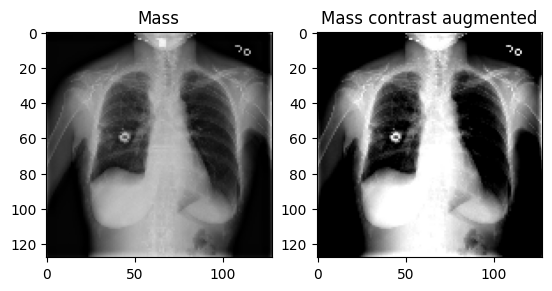

In [11]:
i, stop = (0,0)
for (img, label) in  train_data_augmented.take(1):
    if i == stop:
        break
    i += 1
plot_augmented_images(img, label, stop) 

# Fine tuning model

In [6]:
from tensorflow.keras import layers, Model, regularizers

#import the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB6(include_top=False)
base_model.trainable = True

inputs = tf.keras.Input((128,128,3), name='inputs') 
x = layers.RandomFlip('horizontal')(inputs)
x = layers.RandomBrightness(0.3)(x)
x = base_model(inputs)
#average pooling 
x = layers.GlobalMaxPooling2D()(x)
#outputs
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

fine_tuning_model = tf.keras.Model(inputs = inputs, outputs = outputs)

#compile the model
fine_tuning_model.compile(
                            optimizer = tf.keras.optimizers.Adam(), 
                            loss = tf.keras.losses.categorical_crossentropy,
                            metrics = ['accuracy']
    )

In [7]:
fine_tuning_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb6 (Functional)  (None, None, None, 2304)  40960143 
                                                                 
 global_average_pooling2d_1   (None, 2304)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 64)                147520    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                             

In [37]:
import random 
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
  
history_fine_tuning = fine_tuning_model.fit(
                                    train_data_augmented,
                                    epochs=10,
                                    validation_data=valid_data,
                                    validation_steps=len(valid_data),
                                    callbacks=[checkpoint_callback]
)

Epoch 1/10


2024-01-17 20:33:09.394289: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/efficientnetb6/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


746/746 [==============================] - ETA: 0s - loss: 1.6389 - accuracy: 0.3627
Epoch 1: val_accuracy improved from -inf to 0.29310, saving model to fine_tuning_best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


746/746 [==============================] - 417s 411ms/step - loss: 1.6389 - accuracy: 0.3627 - val_loss: 1.8639 - val_accuracy: 0.2931
Epoch 2/10
746/746 [==============================] - ETA: 0s - loss: 1.4514 - accuracy: 0.4565
Epoch 2: val_accuracy did not improve from 0.29310
746/746 [==============================] - 306s 408ms/step - loss: 1.4514 - accuracy: 0.4565 - val_loss: 2.0314 - val_accuracy: 0.2631
Epoch 3/10
746/746 [==============================] - ETA: 0s - loss: 1.3439 - accuracy: 0.5044
Epoch 3: val_accuracy did not improve from 0.29310
746/746 [==============================] - 306s 408ms/step - loss: 1.3439 - accuracy: 0.5044 - val_loss: 1.9408 - val_accuracy: 0.2887
Epoch 4/10
746/746 [==============================] - ETA: 0s - loss: 1.2301 - accuracy: 0.5523
Epoch 4: val_accuracy improved from 0.29310 to 0.31429, saving model to fine_tuning_best_model.h5
746/746 [==============================] - 309s 412ms/step - loss: 1.2301 - accuracy: 0.5523 - val_loss: 2.

# Evaluate the model

In [5]:
fine_tuning_model = tf.keras.models.load_model(r'C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\6_saved_models\fine_tuning_best_model - Copia.h5')
fine_tuning_model.evaluate(test_data)

64/64 [==============================] - 90s 1s/step - loss: 1.8119 - accuracy: 0.3483


[1.8119393587112427, 0.3482758700847626]

0

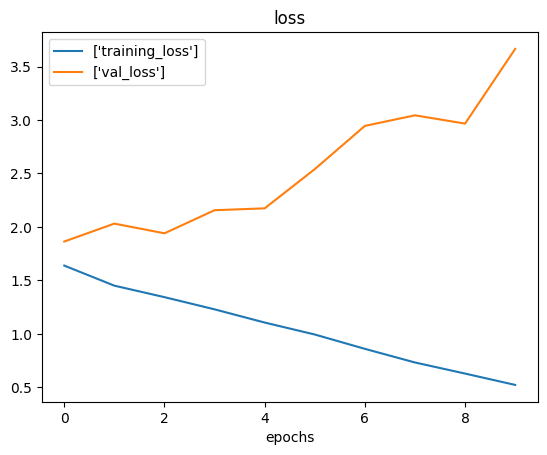

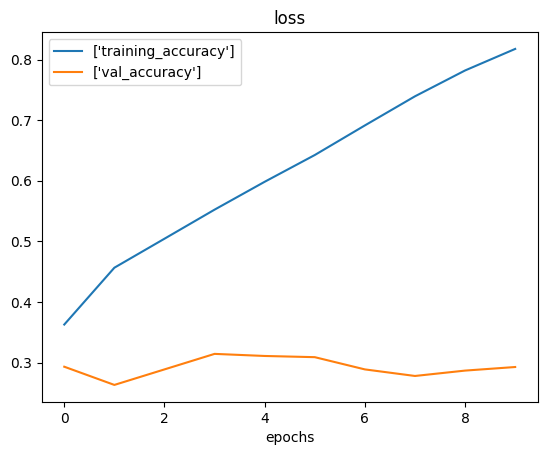

In [41]:
from helper_functions import plot_loss_curve
plot_loss_curve(history_fine_tuning)

## Confusion matrix

In [6]:
from helper_functions import plot_confusion_matrix

# Create test labels and predictions
test_labels = []
for images, labels in test_data.unbatch():
  test_labels.append(tf.argmax(labels).numpy())
test_pred_probs = fine_tuning_model.predict(test_data)
test_predictions = tf.argmax(test_pred_probs, axis=1)

64/64 [==============================] - 90s 1s/step


array([[0.57586207, 0.07241379, 0.06206897, 0.04137931, 0.06896552,
        0.07931034, 0.1       ],
       [0.12758621, 0.54827586, 0.12068966, 0.06206897, 0.00344828,
        0.01724138, 0.12068966],
       [0.20689655, 0.10689655, 0.14482759, 0.03448276, 0.12413793,
        0.15862069, 0.22413793],
       [0.16896552, 0.12068966, 0.0862069 , 0.28275862, 0.02413793,
        0.1862069 , 0.13103448],
       [0.19655172, 0.13103448, 0.1       , 0.06551724, 0.15862069,
        0.16896552, 0.17931034],
       [0.13103448, 0.06551724, 0.10689655, 0.06551724, 0.2137931 ,
        0.25172414, 0.16551724],
       [0.09310345, 0.1       , 0.11034483, 0.05517241, 0.04482759,
        0.12068966, 0.47586207]])

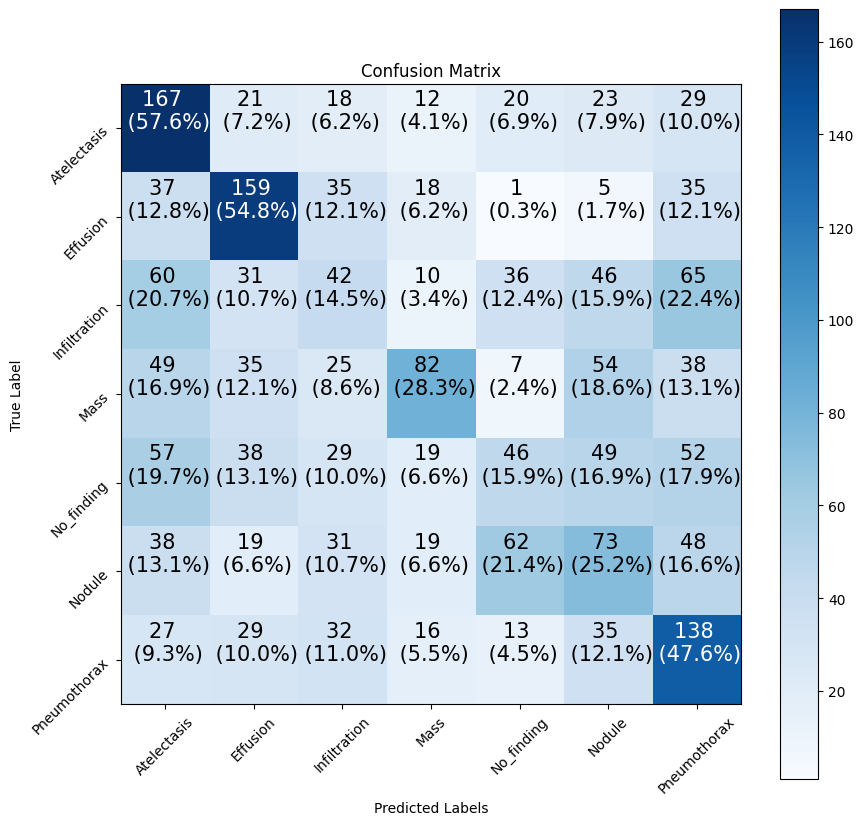

In [7]:
plot_confusion_matrix(test_labels, test_predictions, class_names)

# Results

We can already observe an improvement from the dense model. The model performs as follows:
* atelectasis: 52.4% of alectasis samples are predicted correctly.
* Effusion: 44.5% of effusion samples are predicted correctly, the model confuses it for Infiltration.
* Infiltration: 20% of infiltration samples are predicted correctly. Often confused for No findings.
* Mass: 25.5% of mass samples are predicted correctly. Confused many times for Atelectasis and Infiltration.
* No finding: 44.1% of No finding samples are predicted correctly. 
* Nodule: 3.1% of nodule examples are predicted correctly.The worst performing label. Confused many times for  No finding.
* Pneumothorax: 36.9% of No Pneumothorax samples are predicted correctly.